# Reinforcement Learning
Prof. Milica Gašić

### TD($\lambda$) value function approximation

This notebook is a follow-up of last week. Last week we implemented semi-gradient TD(0) with linear value function approximation. In this notebook, we will add TD($\lambda$) and compare it to TD(0).

As last week, we will represent the value function by a linear combination of features:
$$
\hat{v}(s,w) = x(s)^\top w = \sum_{j=1}^d x(s)_j \, w_j
$$
where $s$ is a state, $x(s) \in \mathbb{R}^d$ is a feature vector of the state, and $w \in \mathbb{R}^d$ is a weight vector.

As a recap, the update rule for semi-gradient TD(0) prediction is given by
$$
w \leftarrow w + \alpha (\underbrace{r_{t+1} + \gamma \hat{v}(s_{t+1}, w) - \hat{v}(s_t, w)}_{\text{TD error}}) \nabla_w \hat{v}(s_t, w)
$$
where $\alpha > 0$ is the learning rate and $\nabla_w \hat{v}(s_t, w)$ is the gradient of the value function with respect to the weight vector.  
For a linear value function the gradient is equal to $\nabla_w \hat{v}(s_t, w) = x(s)$.

To implement (backward-view) semi-gradient TD($\lambda$), we also keep an eligibility vector $E \in \mathbb{R}^d$ in addition to the weight vector.  
The update rule updates the eligibility vector and the weight vector:
$$\begin{aligned}
E & \leftarrow \gamma \lambda E + \nabla_w \hat{v}(s_t, w) \\
w & \leftarrow w + \alpha (\underbrace{r_{t+1} + \gamma \hat{v}(s_{t+1}, w) - \hat{v}(s_t, w)}_{\text{TD error}}) E
\end{aligned}$$

### Implementation

Make sure that the files `rl_env.py` and `rl_tests.py` are in the same folder as the notebook.

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

import rl_env
import rl_tests

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Features

We will work with tabular environments with state space $\mathcal{S} = \{0, 1, \ldots, N\}$,  
where we assume $0$ to be the terminal state and $N$ is the number of non-terminal states.

To apply linear value function approximation, we need a way to convert an integer state $s \in \mathcal{S}$ into a real-valued feature vector $x(s) \in \mathbb{R}^d$.  
Since the value of terminal states is always zero, we don't need a feature vector for terminal state $s = 0$.  
We will consider three types of feature vectors:

**1. One-hot features** (aka table lookup features): $x(s) = \begin{bmatrix} [s = 1], [s = 2], \ldots, [s = N] \end{bmatrix}^\top$.  
In other words, $x(s)$ is an $N$-dimensional vector with a 1 for state $s$ and 0s everywhere else.

**2. State aggregation features**: $x(s) = \begin{bmatrix} [1 \le s \le k], [k + 1 \le s \le 2k], \ldots, [N-k+1 \le s \le N] \end{bmatrix}^\top$.  
In other words, we aggregate states into groups and create a one-hot vector. The size of each group is $k$.

**3. State normalization features**: $x(s) = \begin{bmatrix} (s - 1) / (N - 1) - 0.5 \end{bmatrix}^\top$.  
In other words, we convert the integer into a real value between $-0.5$ and $0.5$ and create a 1-dimensional vector.

The different feature functions were already implemented last week.

In [4]:
class OneHotFeatures:

    def __init__(self, observation_space):
        if not isinstance(observation_space, gym.spaces.Discrete):
            raise ValueError('Observation space must be discrete')

        # number of non-terminal states
        self.num_states = observation_space.n - 1

    def __call__(self, state):

        x = np.zeros(self.num_states)
        x[state - 1] = 1

        return x.astype(np.float32, copy=False)


class StateAggregationFeatures:

    def __init__(self, observation_space, group_size):
        # state 0 is assumed to be the terminal state

        if not isinstance(observation_space, gym.spaces.Discrete):
            raise ValueError('Observation space must be discrete')
        if (observation_space.n - 1) % group_size != 0:
            raise ValueError('Number of non-terminal states must be divisible by group_size')

        self.group_size = group_size

        # number of non-terminal states
        num_states = observation_space.n - 1
        self.num_groups = num_states // group_size

    def __call__(self, state):

        x = np.zeros(self.num_groups)
        x[(state - 1) // self.group_size] = 1

        return x.astype(np.float32, copy=False)


class StateNormalizationFeatures:

    def __init__(self, observation_space):
        if not isinstance(observation_space, gym.spaces.Discrete):
            raise ValueError('Observation space must be discrete')

        # number of non-terminal states
        self.num_states = observation_space.n - 1

    def __call__(self, state):

        x = -0.5 + (state - 1) / (self.num_states -1)
        x = np.array([x])

        return x.astype(np.float32, copy=False)

#### Value functions

We will use the following base class for state value functions:

In [5]:
class ValueFunction:

    def reset(self):
        # reset the value function, e.g. reset the weight vector
        raise NotImplementedError()

    def evaluate(self, state):
        # compute the value of a state
        raise NotImplementedError()

    def update(self, state, target):
        # update the value of a state toward a given target
        raise NotImplementedError()

The following class implements linear value functions and supports TD(0) and TD($\lambda$).  
It stores the weight vector and an eligibility vector, if necessary.  
The learning rate `alpha` is also part of the value function and it will be used in the `update()` method.  
The parameter `feature_fn` is a function that computes a feature vector for a given state.

Your task is to implement the update function, which takes care of TD(0) and TD($\lambda$).

In [13]:
class LinearValueFunction(ValueFunction):

    def __init__(self, observation_space, alpha, gamma, lmbda, feature_fn):
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.lmbda = lmbda  # value for TD(lambda)

        # function that converts a state into a feature vector
        self.feature_fn = feature_fn

        # determine the size of the feature vectors
        # sample a random state and convert it to a feature vector
        sample_features = feature_fn(observation_space.sample())
        if not (isinstance(sample_features, np.ndarray) and len(sample_features.shape) == 1):
            raise ValueError('Features must be real-valued vectors')

        # size of feature vectors (= d)
        self.feature_dim = sample_features.shape[0]

        self.reset()

    def reset(self):
        # create weight vector with size of feature vectors, initialize with zeros
        self.weights = np.zeros(self.feature_dim, dtype=np.float32)

        # create eligibility vector (only when necessary)
        if self.lmbda == 0:
            # not needed for TD(0)
            self.eligibility = None
        else:
            # initialize with zeros
            self.eligibility = np.zeros(self.feature_dim, dtype=np.float32)

    def evaluate(self, state):
        w = self.weights  # weight vector

        state_features = self.feature_fn(state)
        v = np.dot(state_features, w)

        return v

    def update(self, state, target):
        w = self.weights      # weight vector
        e = self.eligibility  # eligibility vector
        alpha = self.alpha    # learning rate
        gamma = self.gamma    # discount factor
        lmbda = self.lmbda    # value for TD(lambda)
        #######################################################################
        # TODO Update the weight vector using one of the update rules         #
        # described above. The parameter `target` contains the TD target, so  #
        # it does not need to be computed here, only the TD error. Update and #
        # use the eligibility vector, only if lmbda != 0. Otherwise use the   #
        # first update rule.                                                  #
        #######################################################################

        x = self.feature_fn(state)
        if lmbda != 0:
            e = gamma * lmbda * e + x
        else:
            e = x
        v_current = self.evaluate(state)
        td_error = target - v_current
        w += alpha * td_error * e

        #######################################################################
        # End of your code.                                                   #
        #######################################################################
        self.weights = w
        self.eligibility = e

You can use the following code cell to test your implementation.  
**Important**: After changing your code, execute the above code cell before running the tests.

In [14]:
def test_linear_value_function():
    yield 'evaluate()'

    obs_space = gym.spaces.Discrete(10)
    feature_fn = lambda s: np.array([float(s), float(s) * 2, float(s) * 3])

    vf = LinearValueFunction(obs_space, alpha=0.1, gamma=0.9, lmbda=0.0, feature_fn=feature_fn)
    vf.weights = np.array([-0.5, 0.4, 0.3])
    for s, expected in zip([1, 2, 5, 10], [1.2, 2.4, 6.0, 12.0]):
        v = vf.evaluate(s)
        yield np.isclose(v, expected), f'The computed value is incorrect (error = {abs(v - expected):.5f})'
        yield None

    yield 'update() with lmbda == 0'

    vf = LinearValueFunction(obs_space, alpha=0.1, gamma=0.9, lmbda=0.0, feature_fn=feature_fn)
    for s, target, expected_w in [(1, 0.4, np.array([0.04, 0.08, 0.12])), (4, 0.65, np.array([-0.59599996, -1.1919999, -1.788]))]:
        vf.update(s, target)
        yield np.allclose(vf.weights, expected_w), f'The updated weights are incorrect (error = {np.sum(np.abs(vf.weights - expected_w)):.5f})'
        yield None

    yield None

    yield 'update() with lmbda != 0'

    vf = LinearValueFunction(obs_space, alpha=0.1, gamma=0.8, lmbda=0.6, feature_fn=feature_fn)
    for s, target, expected_w in [(2, 0.3, np.array([0.06, 0.12, 0.18])), (5, -0.1, np.array([-2.5028, -5.0056, -7.5084]))]:
        vf.update(s, target)
        yield np.allclose(vf.weights, expected_w), f'The updated weights are incorrect (error = {np.sum(np.abs(vf.weights - expected_w)):.5f})'
        yield None

    yield None

rl_tests.run_tests(test_linear_value_function())

Testing evaluate()...
4/4 tests passed!

Testing update() with lmbda == 0...
3/3 tests passed!

Testing update() with lmbda != 0...
3/3 tests passed!


### Evaluation

We will evaluate the algorithms on the 1000-state random walk environment from the lecture.  
To compare the estimated values to the true values, we load them from the file `random-walk-1000.npy`:

In [15]:
true_values = np.load('random-walk-1000.npy')

Now we evaluate TD(0) and TD($\lambda$) using the three types of features.  
We plot the estimated values for all states after 100, 500, and 5000 episodes.  
What do you observe?

Episode 100


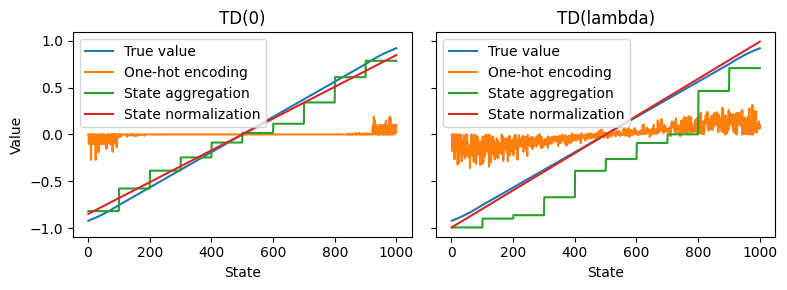

Episode 500


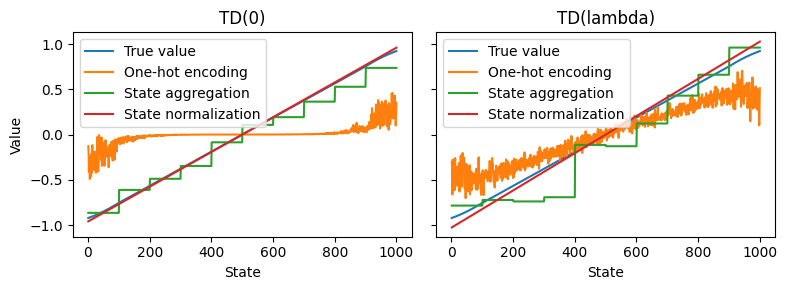

Episode 5000


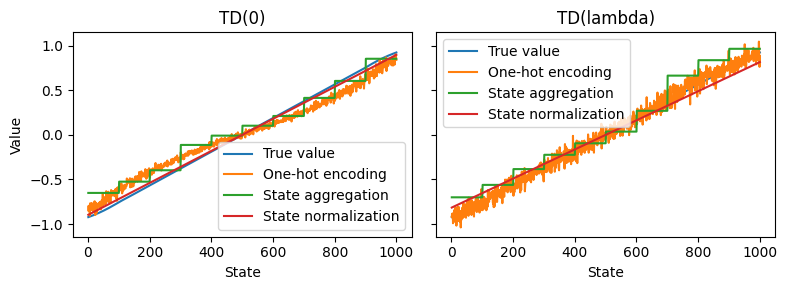

In [16]:
# create an instance of the environment
env = rl_env.RandomWalk1000Env()

gamma = 1.0   # discount factor
lmbda = 0.9   # value for TD(lambda)
alpha = 0.1   # learning rate

# evaluate the value functions after these episodes
milestones = [100, 500, 5000]
num_episodes = milestones[-1]

# create feature functions
observation_space = env.observation_space
one_hot_features = OneHotFeatures(observation_space)
aggregation_features = StateAggregationFeatures(observation_space, group_size=100)
normalization_features = StateNormalizationFeatures(observation_space)

# create linear value functions for TD(0)
one_hot_vf = LinearValueFunction(observation_space, alpha, gamma, 0, one_hot_features)
aggregation_vf = LinearValueFunction(observation_space, alpha, gamma, 0, aggregation_features)
normalization_vf = LinearValueFunction(observation_space, alpha, gamma, 0, normalization_features)

# create linear value functions for TD(lambda)
one_hot_lambda_vf = LinearValueFunction(observation_space, alpha, gamma, lmbda, one_hot_features)
aggregation_lambda_vf = LinearValueFunction(observation_space, alpha, gamma, lmbda, aggregation_features)
normalization_lambda_vf = LinearValueFunction(observation_space, alpha, gamma, lmbda, normalization_features)

td_0_vfs = [one_hot_vf, aggregation_vf, normalization_vf]
td_lambda_vfs = [one_hot_lambda_vf, aggregation_lambda_vf, normalization_lambda_vf]
labels = ['One-hot encoding', 'State aggregation', 'State normalization']

for episode in range(num_episodes):
    state, _ = env.reset()
    while True:
        action = 0  # Markov reward process, one action with no meaning
        next_state, reward, terminated, truncated, _ = env.step(action)

        # update all value functions
        for vf in td_0_vfs + td_lambda_vfs:
            # compute the TD target
            if terminated:
                target = reward
            else:
                target = reward + gamma * vf.evaluate(next_state)
            # update the value function
            vf.update(state, target)

        if terminated or truncated:
            break

        state = next_state

    if (episode + 1) in milestones:
        # compute and plot the values for all states

        print(f'Episode {episode + 1}')

        fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)
        axes[0].set_title('TD(0)')
        axes[1].set_title('TD(lambda)')
        axes[0].set_xlabel('State')
        axes[1].set_xlabel('State')
        axes[0].set_ylabel('Value')

        num_states = env.observation_space.n
        states = np.arange(1, num_states)
        axes[0].plot(states, true_values, label='True value')
        axes[1].plot(states, true_values, label='True value')

        for vf, label in zip(td_0_vfs, labels):
            values = np.zeros(num_states)
            for state in range(num_states):
                values[state] = vf.evaluate(state)
            axes[0].plot(states, values[1:], label=label)

        for vf, label in zip(td_lambda_vfs, labels):
            values = np.zeros(num_states)
            for state in range(num_states):
                values[state] = vf.evaluate(state)
            axes[1].plot(states, values[1:], label=label)

        axes[0].legend()
        axes[1].legend()
        fig.tight_layout()
        plt.show()